# Stock Market Prediction

### Student name: Federico Berto 
### Student ID: 20204817

## Introduction to Financial Engineering [IE471]

### 1. Import Packages
#### Please import pandas_datareader package using 'pip install pandas_datareader'.

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

import pytorch_lightning as pl # Use Pytorch Lightning

def dummy_trainloader():
    tl = DataLoader(TensorDataset(torch.Tensor(1), torch.Tensor(1)), batch_size=1)
    return tl

import sys; sys.path.append('../') # Import from src/
from src.utils import Snake

## 1B. Custom Activation Function
We use the custom $Snake$ activation function:
$$Snake_a := x + \frac{1}{a} sin^2(ax)$$

This function is better suited to learn periodicities and it is proven to extrapolate better when compared to other activations such as $ReLU$ or $tanh$.
References: 
- Neural Networks Fail to Learn Periodic Functions and How to Fix It https://arxiv.org/abs/2006.08195
- Original implementation: https://github.com/EdwardDixon/snake
- My Github version (merged pull request in the master above): https://github.com/Juju-botu/snake


In [2]:
?? Snake

Init signature:  Snake(in_features, a=None, trainable=True)
Docstring:     
Implementation of the serpentine-like sine-based periodic activation function

.. math::
     Snake_a := x + rac{1}{a} sin^2(ax) = x - rac{1}{2a}cos{2ax} + rac{1}{2a}

Shape:
    - Input: (N, *) where * means, any number of additional
      dimensions
    - Output: (N, *), same shape as the input
    
Parameters:
    - a - trainable parameter

References:
    - This activation function is from this paper by Liu Ziyin, Tilman Hartwig, Masahito Ueda:
    https://arxiv.org/abs/2006.08195
    
Examples:
    >>> a1 = snake(256)
    >>> x = torch.randn(256)
    >>> x = a1(x)
Source:        
class Snake(nn.Module):
    '''         
    Implementation of the serpentine-like sine-based periodic activation function
    
    .. math::
         Snake_a := x + \frac{1}{a} sin^2(ax) = x - \frac{1}{2a}cos{2ax} + \frac{1}{2a}

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
  

In [3]:
# from torch import Tensor
# from torch.nn import Parameter
# from typing import List, Tuple

# class SnakeLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(SnakeLSTM, self).__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.weight_ih = Parameter(torch.randn(4 * hidden_size, input_size))
#         self.weight_hh = Parameter(torch.randn(4 * hidden_size, hidden_size))
#         self.bias_ih = Parameter(torch.randn(4 * hidden_size))
#         self.bias_hh = Parameter(torch.randn(4 * hidden_size))

#     def forward(self, input: Tensor, state: Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]:
#         hx, cx = state
#         print(input.shape, self.weight_ih.t().shape)
#         gates = (torch.mm(input, self.weight_ih.t()) + self.bias_ih +
#                  torch.mm(hx, self.weight_hh.t()) + self.bias_hh)
#         ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

#         ingate = torch.sigmoid(ingate)
#         forgetgate = torch.sigmoid(forgetgate)
#         cellgate = torch.tanh(cellgate)
#         outgate = torch.tanh(outgate)

#         cy = (forgetgate * cx) + (ingate * cellgate)
#         hy = outgate * torch.tanh(cy)

#         return hy, (hy, cy)

### 2. Loading the Dataset

In [4]:
start = (2000, 1, 1)  # 2000-01-01 
start_time = datetime.datetime(*start)  
end = (2020, 12, 31) # 2020-12-31
end_time = datetime.datetime(*end) 

# Loading Samsung Electronic Co,. Ltd. (KS: 005930) Data from Yahoo Finance
df = pdr.DataReader('005930.KS', 'yahoo', start_time, end_time)

High : HIgh Price, The highest price at which a stock traded during that particular day

Low : Low Price, The lowest price at which a stock traded during that particular day

Open : Open Price, The stock price at which opens at the start of market

Close : Close Price, The stock closing at the end of the market hours

Volume : Trading volume during that particular day

Adj Close : A stock's closing price to reflect that stock's value after accounting for any corporate actions (Reference: https://help.yahoo.com/kb/SLN28256.html)

In [5]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-04,6110.0,5660.0,6000.0,6110.0,74195000.0,4761.183105
2000-01-05,6060.0,5520.0,5800.0,5580.0,74680000.0,4348.184082
2000-01-06,5780.0,5580.0,5750.0,5620.0,54390000.0,4379.354004
2000-01-07,5670.0,5360.0,5560.0,5540.0,40305000.0,4317.015625
2000-01-10,5770.0,5580.0,5600.0,5770.0,46880000.0,4496.240723


In [6]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-23,74000.0,72300.0,72400.0,73900.0,19411326.0,72085.835938
2020-12-24,78800.0,74000.0,74100.0,77800.0,32502870.0,75890.093750
2020-12-28,80100.0,78200.0,79000.0,78700.0,40085044.0,76768.000000
2020-12-29,78900.0,77300.0,78800.0,78300.0,30339449.0,78300.000000
2020-12-30,81300.0,77300.0,77400.0,81000.0,29417421.0,81000.000000


In [7]:
X = df # Using high price, low price, Open price, Close price, Volume, and Adjusted Close Price to predict adjusted close price
y = df.iloc[:, 5:6] #Predicting adjusted close price

### 3. Scaling and Converting Data

We can see that there is a big difference between volume and other values. In this case, LSTM models need to recognize the difference between these two scales: volume and the rest values, which can be a burden to train data. Therefore, we reduce by scaling all variables from 0 to 1 to reduce the burden on the model.

In [8]:
MMS = MinMaxScaler()


X_data = MMS.fit_transform(X)
y_data = MMS.fit_transform(y) 

# Input Variables (6 variables)
X_train = X_data[:4781, :] #We trained 2000 - 2018 data including high price, low price, open price, close price, volume, and adj close data
X_test = X_data[4781:, :] #To verify trained model, we used 2019 - 2020 data as the test set

# Output Variables (adjusted close price)
y_train = y_data[:4781, :]
y_test = y_data[4781:, :] 

print("Training Set Shape", X_train.shape, y_train.shape)
print("Testing Set Shape", X_test.shape, y_test.shape) 

Training Set Shape (4781, 6) (4781, 1)
Testing Set Shape (493, 6) (493, 1)


In [9]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([4781, 1, 6]) torch.Size([4781, 1])
Testing Shape torch.Size([493, 1, 6]) torch.Size([493, 1])


In [10]:
device = torch.device('cpu')

### 4. Building LSTM Model

In [11]:
class SnakeLSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, use_snake=True):
    super(SnakeLSTM, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #LSTM layer
    self.fc = nn.Linear(hidden_size, num_classes) #fully connected last layer to capture periodicity
    self.use_snake = use_snake
    if self.use_snake:  
        self.snake = Snake(hidden_size, num_classes) # activation function before last layer
#         self.snake = Snake(input_size) # activation function before last layer

  def forward(self,x):
    h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM
#     if self.use_snake: x = self.snake(x)
    out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
    # Decode the hidden state of the last time step
    # Apply activation function if required
    if self.use_snake: out = self.fc(out[:, -1, :])
    else: out = self.fc(out[:, -1, :])
#   out = self.fc(out[:, -1, :])
    return out

### 5. Setting Hyperparameters and Training Data

In [12]:
num_epochs = 5000
learning_rate = 0.001

input_size = 6 # number of features
hidden_size = 2 #2 # number of features in hidden state
num_layers = 1 #1 # number of stacked LSTM layers
seq_length = 5 # To predict adj close price of sixth day using data of 5 previous days
num_classes = 1 #number of output classes 

# LSTM_1 = LSTM_model(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

# loss_function = torch.nn.MSELoss()    # mean-squared error for regression
# optimizer = torch.optim.Adam(LSTM_1.parameters(), lr=learning_rate)  # adam optimizer

In [13]:
## Pytorch Lightning Module

class LitSnakeLSTM(pl.LightningModule):

    def __init__(self, use_snake=True):
        super().__init__()
        self.lstm = SnakeLSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1], use_snake=use_snake).to(device)
        self.loss = torch.nn.MSELoss() 

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        out = self.lstm(x)
        return out

    def training_step(self, batch, batch_idx):
        out = self(X_train_tensors_final.to(device))
        loss = self.loss(out, y_train_tensors.to(device))        
        self.log('train_loss', loss)
        return loss
    
    def validation_step():
        out = self(X_test_tensors_final.to(device))
        val_loss = self.loss(out, y_test_tensors.to(device))
        self.log('val_loss', val_loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer
    
    def train_dataloader(self):
        return trainloader

## Without `Snake`

In [14]:
from pytorch_lightning.loggers import WandbLogger

# logger = WandbLogger(project='finance_project_1')
trainloader= dummy_trainloader()
pl_lstm = LitSnakeLSTM(use_snake=False)
trainer = pl.Trainer(max_epochs=5000)
trainer.fit(pl_lstm)

GPU available: True, used: False
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
/home/fedebotu/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
/home/fedebotu/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name | Type      | Params
-----------------------------------
0 | lstm | SnakeLSTM | 83    
1 | loss | MSELoss   | 0     

  | Name | Type      | Params
-----------------------------------
0 | lstm | SnakeLSTM | 83    
1 | loss | MSELoss   | 0     


/home/fedebotu/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

## With `Snake`

In [15]:
trainloader= dummy_trainloader()
snake_pl_lstm = LitSnakeLSTM(use_snake=True)
trainer = pl.Trainer(max_epochs=5000)
trainer.fit(snake_pl_lstm)

GPU available: True, used: False
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores

  | Name | Type      | Params
-----------------------------------
0 | lstm | SnakeLSTM | 85    
1 | loss | MSELoss   | 0     

  | Name | Type      | Params
-----------------------------------
0 | lstm | SnakeLSTM | 85    
1 | loss | MSELoss   | 0     


1

In [16]:
plt.rcParams["figure.figsize"] = (32,18)
plt.rcParams["figure.dpi"] = 300
plt.rcParams['axes.grid'] = True 
plt.rcParams.update({'font.size': 20})

### 6. Results

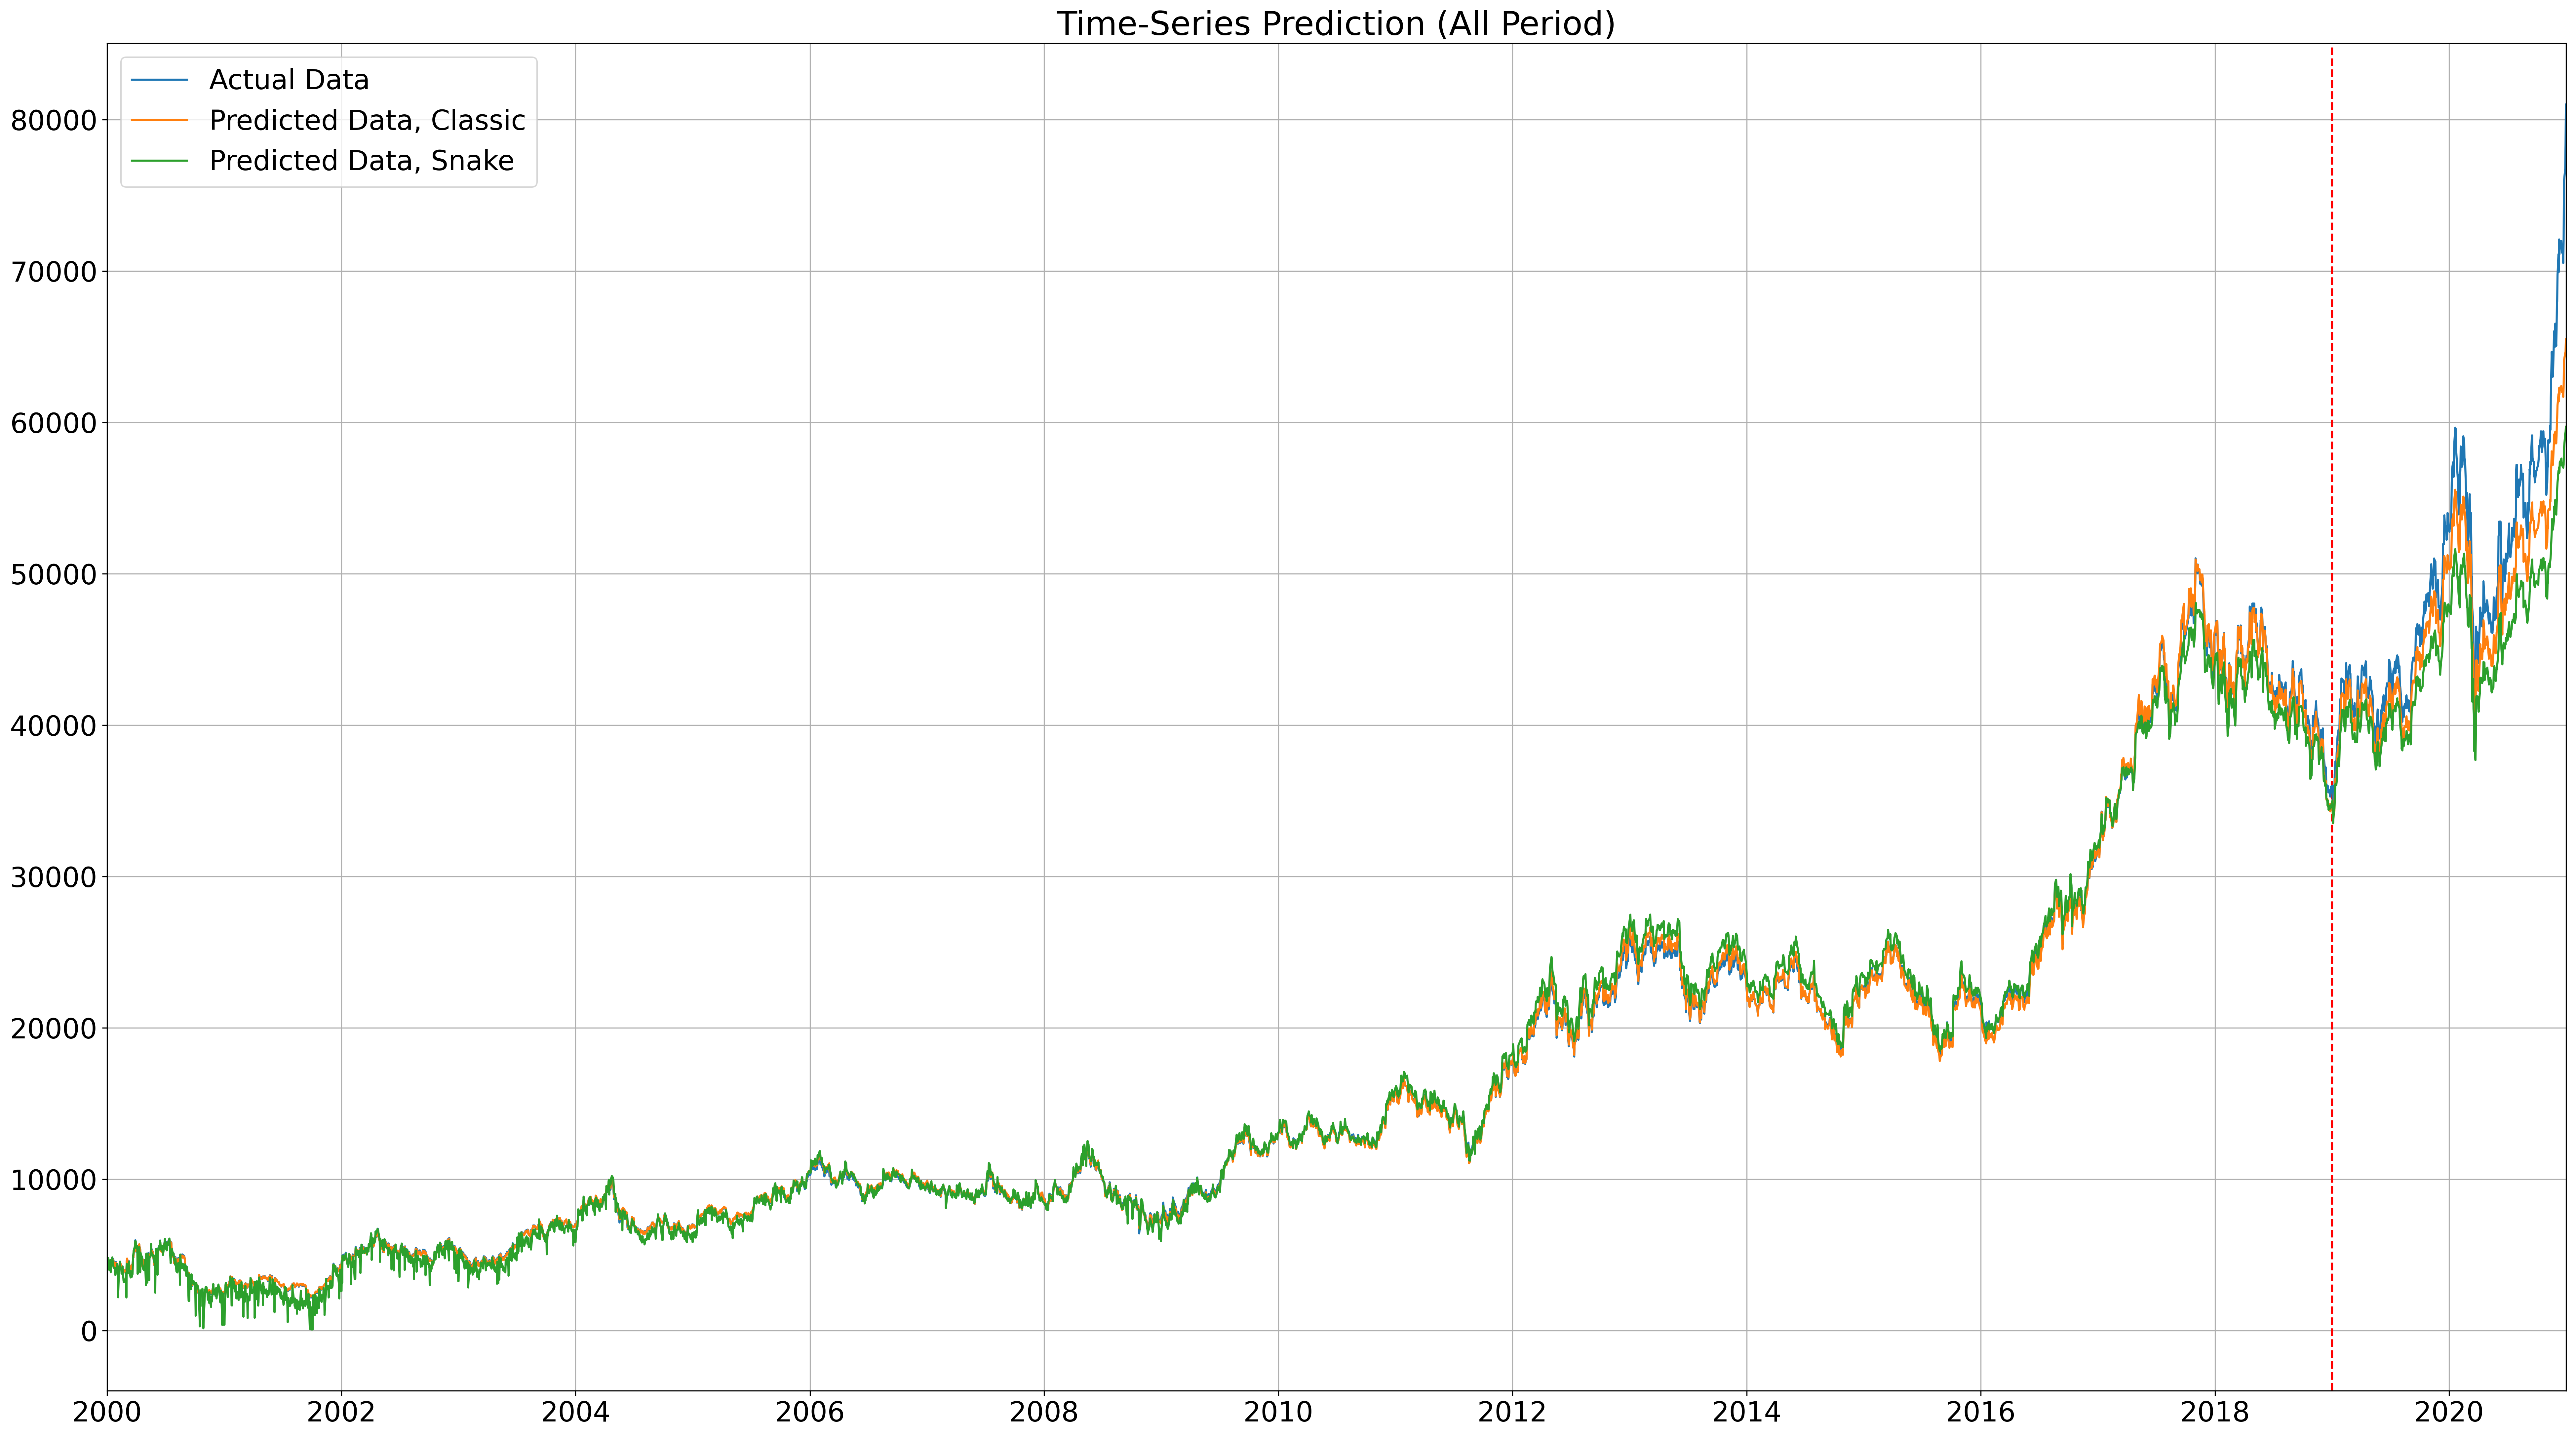

In [17]:
X_data = MMS.fit_transform(X)
y_data = MMS.fit_transform(y) 

df_X = Variable(torch.Tensor(X_data)) #converting to Tensors
df_y = Variable(torch.Tensor(y_data))
#reshaping the dataset
df_X = torch.reshape(df_X, (df_X.shape[0], 1, df_X.shape[1]))

# Without Snake
train_predict = pl_lstm(df_X.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
classic_data_predict = MMS.inverse_transform(data_predict) #reverse transformation

# With Snake
train_predict = snake_pl_lstm(df_X.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
snake_data_predict = MMS.inverse_transform(data_predict) #reverse transformation

dataY_plot = df_y.data.numpy()
dataY_plot = MMS.inverse_transform(dataY_plot)

plt.xlim(datetime.datetime(2000, 1, 1), datetime.datetime(2020, 12, 31))
test_line = datetime.datetime(2019, 1, 1)
plt.axvline(x=test_line, c='r', linestyle='--') #size of the training set

plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), classic_data_predict, label='Predicted Data, Classic') # plot for predicted data
plt.plot(df.index.to_pydatetime(), snake_data_predict, label='Predicted Data, Snake') # plot for predicted data
plt.title('Time-Series Prediction (All Period)')
plt.legend()
plt.show() 

In [18]:
MSE = float(sum((dataY_plot - classic_data_predict)*(dataY_plot - classic_data_predict))/len(classic_data_predict))
MSE_snake = float(sum((dataY_plot - snake_data_predict)*(dataY_plot - snake_data_predict))/len(snake_data_predict))
print('Mean Squared Error Classic:', MSE)
print('Mean Squared Error Snake:', MSE_snake)

Mean Squared Error Classic: 1049088.125
Mean Squared Error Snake: 3686385.25


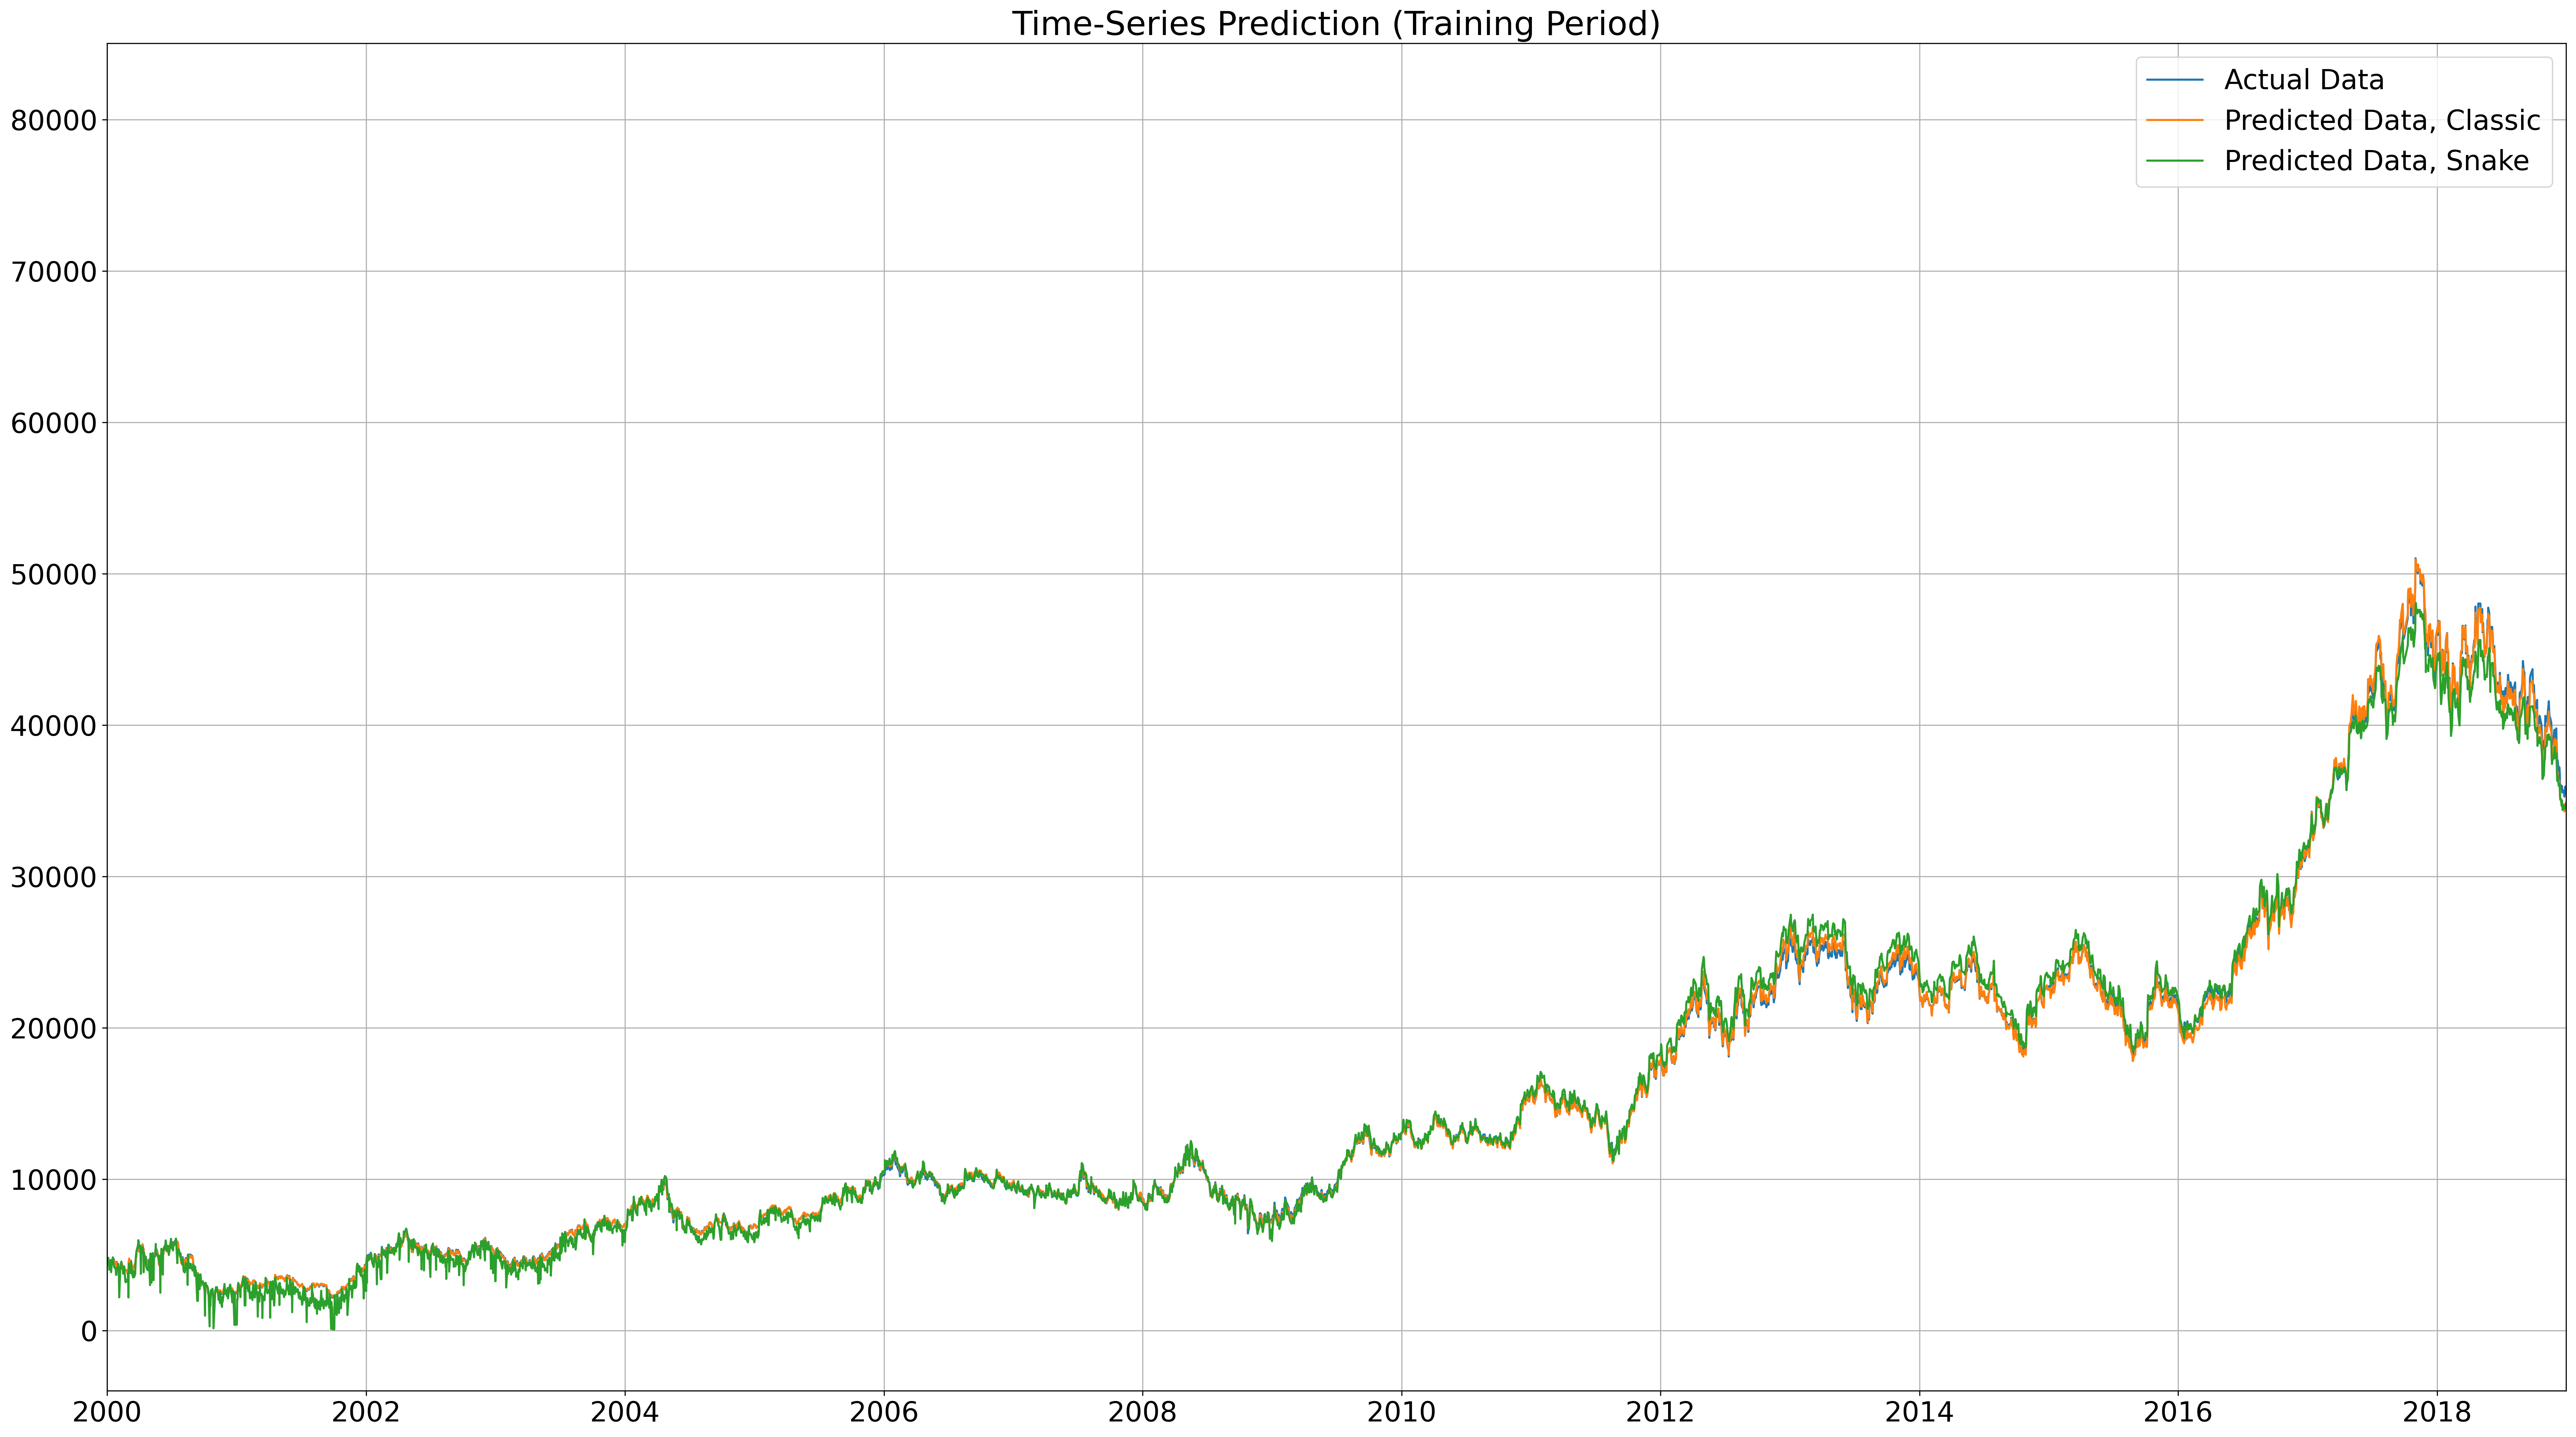

In [19]:
plt.xlim(datetime.datetime(2000, 1, 1), datetime.datetime(2018, 12, 31))
plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), classic_data_predict, label='Predicted Data, Classic') # plot for predicted data
plt.plot(df.index.to_pydatetime(), snake_data_predict, label='Predicted Data, Snake') # plot for predicted data
plt.title('Time-Series Prediction (Training Period)')
plt.legend()
plt.show() 

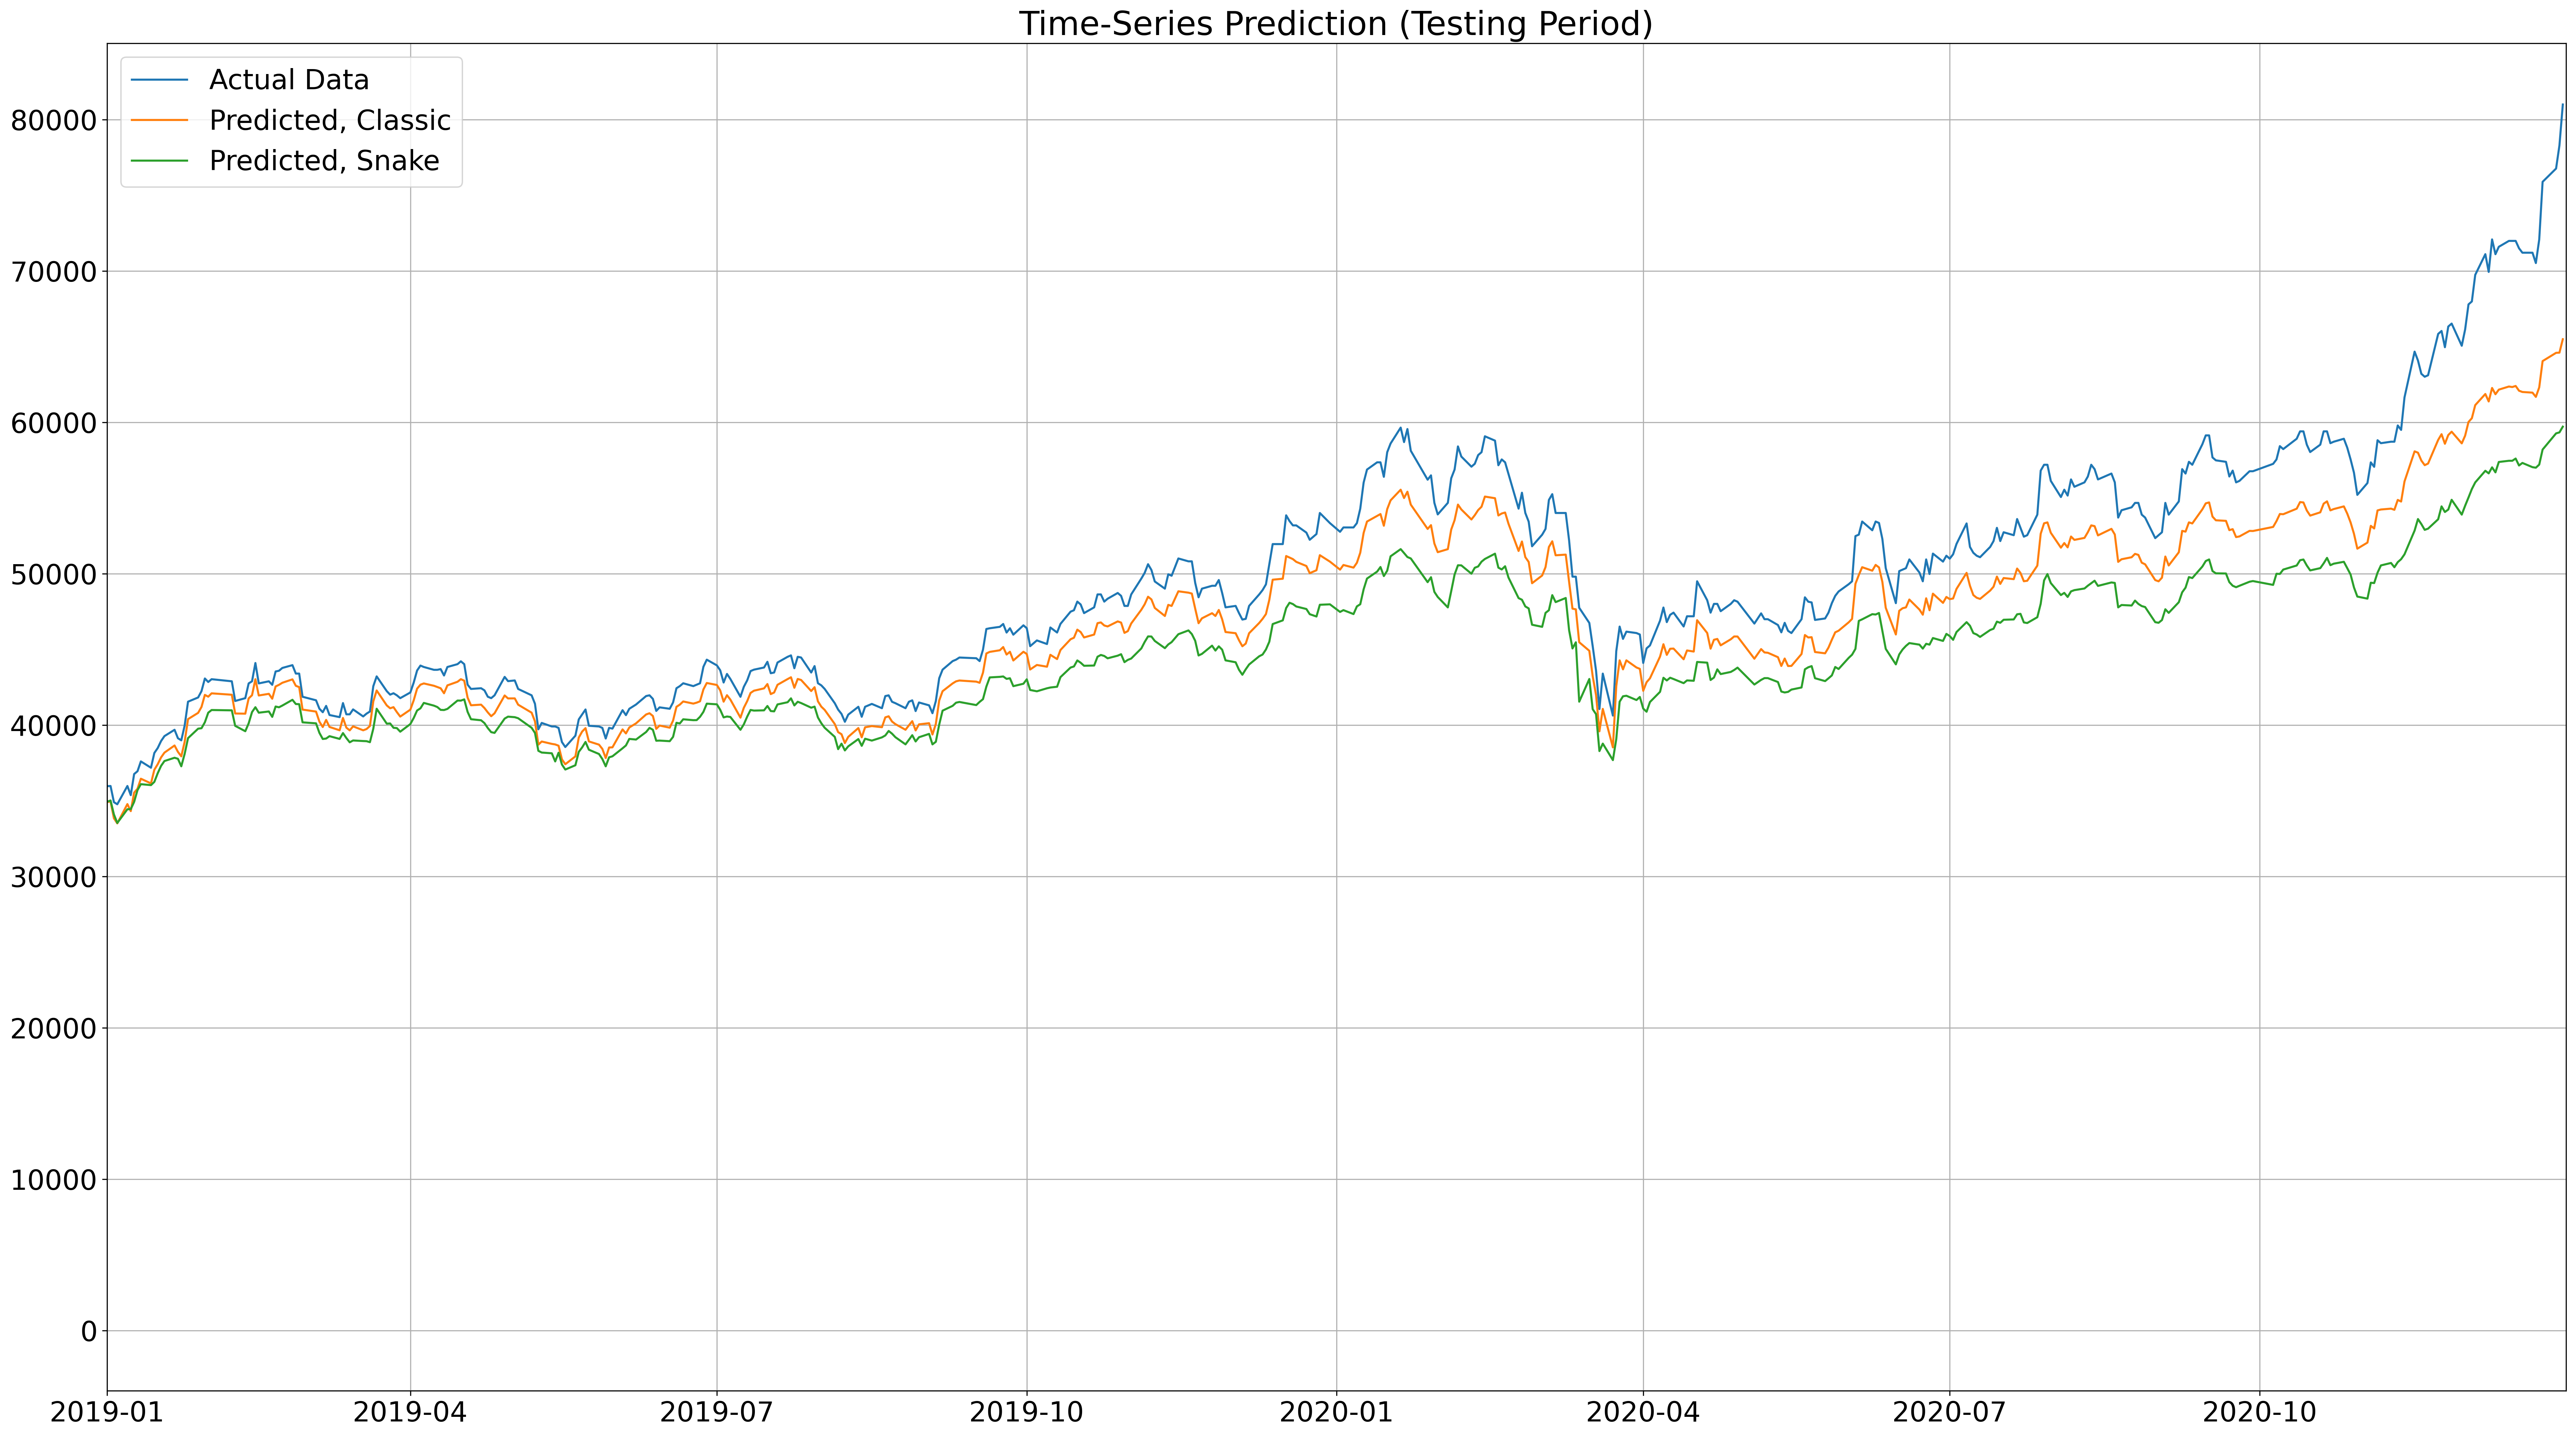

In [20]:
plt.xlim(datetime.datetime(2019, 1, 1), datetime.datetime(2020, 12, 31))
plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), classic_data_predict, label='Predicted, Classic') # plot for predicted data
plt.plot(df.index.to_pydatetime(), snake_data_predict, label='Predicted, Snake') # plot for predicted data
plt.title('Time-Series Prediction (Testing Period)')
plt.legend()
plt.show() 